# SIIM ISIC Melanoma Classification EDA
The data has been provided in various formats. Such as TFRecord, Dicom and JPEG. We will work with TFRecord files and later use them for training due to faster read speeds.

## Importing Libraries

In [1]:
!pip install gcsfs --quiet
!pip install fsspec --quiet

     |████████████████████████████████| 122kB 8.1MB/s 
     |████████████████████████████████| 1.3MB 41.6MB/s 
     |████████████████████████████████| 143kB 58.4MB/s 
     |████████████████████████████████| 296kB 57.6MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
from google.colab import auth
auth.authenticate_user()

## Loading the data

In [4]:
gcs_path = 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf'

In [5]:
!gsutil ls {gcs_path}

gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/sample_submission.csv
gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/test.csv
gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/train.csv
gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/jpeg/
gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/test/
gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/
gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/train/


In [6]:
df = pd.read_csv(gcs_path + '/train.csv')

In [7]:
df.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0


In [8]:
print('total no of rows: ', len(df))

total no of rows:  33126


In [9]:
print('total unique patients: ', df['patient_id'].nunique(), ', images: ', df['image_name'].nunique())

total unique patients:  2056 , images:  33126


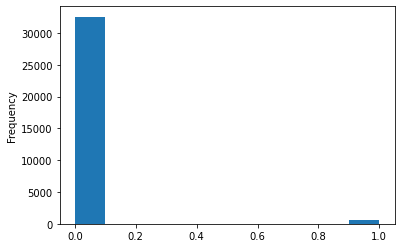

In [10]:
# Distribution of target
df['target'].plot(kind='hist')

In [11]:
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

**The dataset is highly imbalanced**

In [12]:
# Are all the images corresponding to a patients have same target value

for group, frame in df.groupby(by='patient_id'):

  value = frame['target'].values[0]
  total_target = len(frame[frame['target'] == value])

  if (len(frame) != total_target):
    print('not all same')
    display(frame)
    break

not all same


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
1751,ISIC_0626653,IP_0038545,female,60.0,torso,unknown,benign,0
4906,ISIC_1574374,IP_0038545,female,55.0,torso,unknown,benign,0
5246,ISIC_1666715,IP_0038545,female,55.0,lower extremity,unknown,benign,0
5663,ISIC_1796387,IP_0038545,female,55.0,upper extremity,unknown,benign,0
6454,ISIC_2027582,IP_0038545,female,45.0,upper extremity,melanoma,malignant,1
6684,ISIC_2096870,IP_0038545,female,55.0,upper extremity,unknown,benign,0
6921,ISIC_2163734,IP_0038545,female,55.0,torso,unknown,benign,0
7094,ISIC_2216568,IP_0038545,female,55.0,torso,unknown,benign,0
14301,ISIC_4379945,IP_0038545,female,60.0,upper extremity,unknown,benign,0
14384,ISIC_4406292,IP_0038545,female,60.0,head/neck,unknown,benign,0


This shows that the target is strictly dependent on the image rather than the patient unlike in radiology.

## Looking at some images

In [13]:
image_paths = gcs_path + '/tfrecords/train*.tfrec'
filenames = tf.io.gfile.glob(image_paths)

In [14]:
filenames

['gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train00-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train01-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train02-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train03-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train04-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train05-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train06-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train07-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train08-2071.tfrec',
 'gs://kds-b1f1cf4da1faf4a918d95fa8cdf0c0cd7d9f879a503b9d833821dbaf/tfrecords/train09-2071.tfrec',
 'gs://kds

In [15]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'  : tf.io.FixedLenFeature([], tf.string),
        'target' : tf.io.FixedLenFeature([], tf.int64)
    }           

    example = tf.io.parse_single_example(example, tfrec_format)

    return example['image'], example['target']

def read_image(img, target):
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (512, 512))
  img = img/255.
  return img, target

In [16]:
ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=-1)
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=-1)
ds = ds.map(read_image, num_parallel_calls=-1)

In [17]:
# See a sample Image
sample_images = []
sample_target = []
for i in ds.take(8):
  sample_images.append(i[0])
  sample_target.append(i[1].numpy())

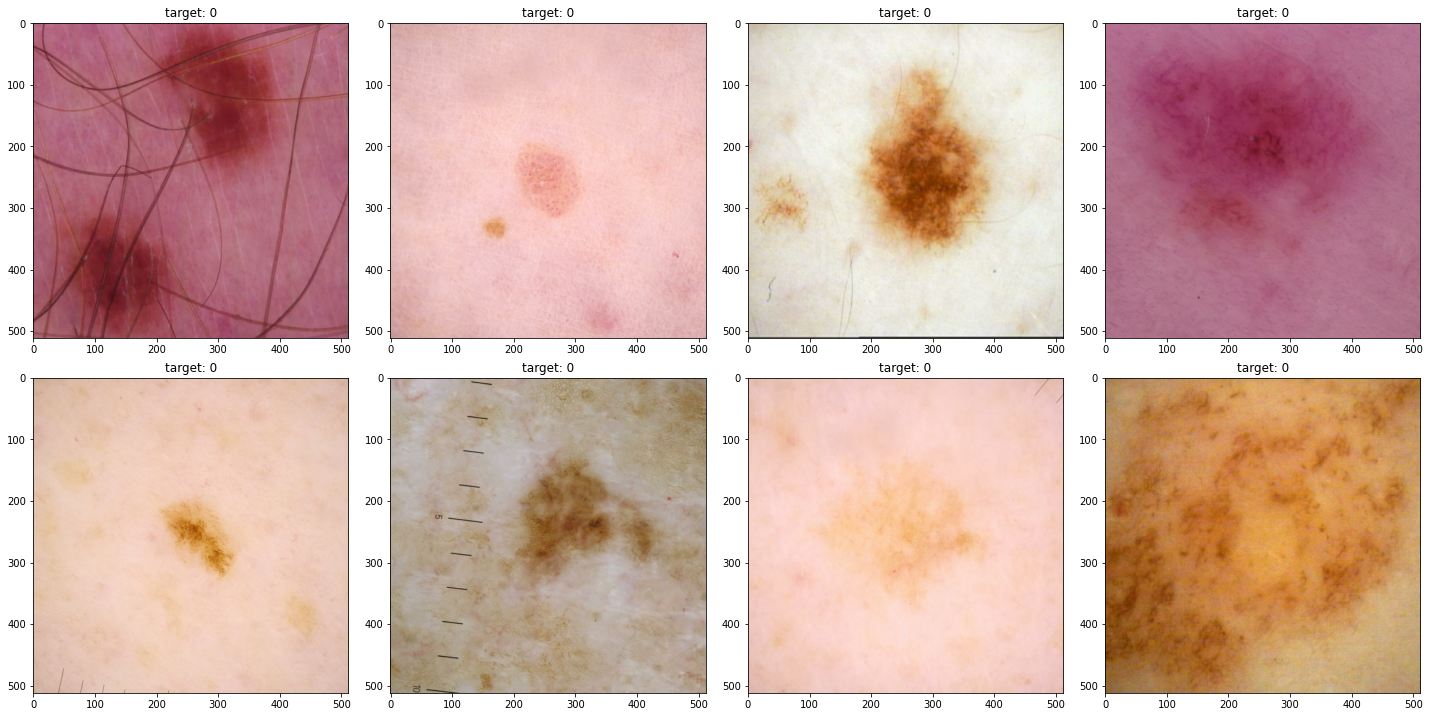

In [18]:
plt.figure(figsize=(20,10))
for idx, value in enumerate(range(8)):
  plt.subplot(2,4, idx+1)
  plt.imshow(sample_images[idx])
  plt.title(f'target: {sample_target[idx]}')
plt.tight_layout()

## Fast model Prototyping

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [20]:
AUTO = tf.data.experimental.AUTOTUNE

In [37]:
def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
  }

  example = tf.io.parse_single_example(example, features)

  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  # image_tensor = tf.reshape(normalized, [512, 512, 3])
  image_tensor = tf.image.resize(normalized, [512, 512])
  return image_tensor, example['target']

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(filenames)

  def data_augment(image, target):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, target

  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  return augmented.repeat().shuffle(2048).batch(256).prefetch(AUTO) 

training_dataset = get_training_dataset()

In [38]:
for i in training_dataset:
  print(i[0].shape)
  break

(256, 512, 512, 3)


In [39]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[512, 512, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = tf.keras.metrics.AUC()
  )
  return model

with tpu_strategy.scope():
  model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [40]:
history = model.fit(training_dataset, steps_per_epoch=5000, epochs=5)